In [ ]:
# ab testing
# natural experiments <- need to find a suitable dataset for this -- if i can't ill just create one
# regression

In [1]:
# mobile gaming dataset
# quite large tens of thousands of observations
# experimental set up
# we have a mobile game (a game you play on your cell phone)
# what happens to total number of games played from the moment the experiment was launched to 14 days after
# and retention .. after 1 day and after 7 days.
# treatment/experimental condition - "the thing that's different between the two groups"
# group A sees the gate at level 30
# group B sees the gate at level 40
# prior to the experiment ALL players saw the gate at level 30

import numpy as np
import pandas as pd
cats = pd.read_csv('cookie_cats.csv')
cats.head(4)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False


In [3]:
print(cats.shape)
cats.version.value_counts()


(90189, 5)


version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [ ]:
# what makes experiments valid - why are they the best way to answer causal questions
# we ensure that the treatment and control groups are comparable
# we achieve this through random assignment of treatment and control

`avg(y | gate_40) - avg(y | gate_30) = effect of the treatment + bias`

effect of treatment = "the difference between y under the treatment vs under no treatment...specifically for the people who did get the treatment"

bias = "if no one got the treatment what would be the difference in y (games played) between the gate_40 people and the gate_30 people"

bias -> 0 under random assignment

In [4]:
# sum_gamerounds (numeric) ~ versions (categorical (gate_30, gate_40))
# anyone know the right hypothesis test
# t-test

# two-sample unpaired t test

# two-sample - we have two groups, A and B, gate_30, gate_40
# if you only have raw data from one group, and from the other group you only have the mean
# that would be a one-sample t test
# unpaired
# if this was paired -> the same group would see gate_30 for 2 weeks, then they would see gate_40 for another 2 weeks.

# null hypothesis
# avg(y | gate_40) - avg(y | gate_30) = 0

# alternative
# avg(y | gate_40) - avg(y | gate_30) != 0

# one-tailed vs two-tailed (two-tailed test)
gate_30_gr = cats.loc[cats['version'] == 'gate_30','sum_gamerounds']
gate_40_gr = cats.loc[cats['version'] == 'gate_40','sum_gamerounds']

In [5]:
from scipy.stats import ttest_ind
ttest_ind(gate_30_gr,gate_40_gr)

TtestResult(statistic=0.8910426211362967, pvalue=0.37290868247405207, df=90187.0)

interpretation:

we fail to reject the null hypothesis

pvalue

if we reject the null hypothesis - that is considered a "positive" result. we have a finding.
if we incorrectly reject the null hypothesis (i.e. we believe there's an effect but in reality there's not)
we made a false positive = type 1 error

pvalue = the probability of false positive

pvalue = "in a world where there is no real effect we expect to see the data we collected from our experiment, about pvalue percent of the time."


we've done this experiment, and now we want to explain where the variability in the data comes from

1. all the variability is due to the systematic effect of the treatment <- no way

gate_30_gr = (120, 120, 120, 120, ....)
gate_40_gr = (119, 119, 119, 119, ....)

2. all the variability is due to randomness/bias (noise) <- when we do a hypothesis test, we're testing this
3. the variability is some combination of systematic effect and noise


In [15]:
#sum_gamerounds ~ 3+ versions

# retention variable
# 7 day retention (rate, category) ~ version (categorical (gate_30,40))

# if you did an anova - it would not throw an error and it would not be totally meaningless

# general point about stats tools/models - there are better and worse tools, and they live on a spectrum

# what is the test for this kind of data
# z test for proportions

# what are the null/alt hypotheses
# null: retention rate gate_30 = retention_rate gate_40
# alt: ~null retention rate gate_30 != retention_rate gate_40

from statsmodels.stats.proportion import proportions_ztest

nobs = [cats.loc[cats['version'] == 'gate_30'].shape[0],cats.loc[cats['version'] == 'gate_40'].shape[0]]
counts = list(cats.groupby('version')['retention_7'].sum())

proportions_ztest(counts,nobs)

(3.164358912748191, 0.0015542499756143289)

In [16]:
cats.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

In [24]:
# general point about stats tools/models - there are better and worse tools, and they live on a spectrum
# sum_gamerounds (numeric) ~ versions (categorical (gate_30, gate_40))
# t-test - this is great, it was designed for this specifically

# sum_gamerounds = (10,3,100,...)
# version = (0,0,1,...)

# sum_gamerounds = f(version)
# f: linear regression

# sum_gamerounds = f(version) = intercept + beta_version*version{1,0}

X = np.where(cats['version'] == 'gate_30',0,1).T.reshape(-1,1)
y = cats['sum_gamerounds']

from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(X,y)


LinearRegression()

In [26]:
predictions = m.intercept_ + m.coef_*X

In [29]:
m.coef_

array([-1.15748845])

In [28]:
m.score(X,y) # r-squared is bad close to zero

8.803374801025221e-06

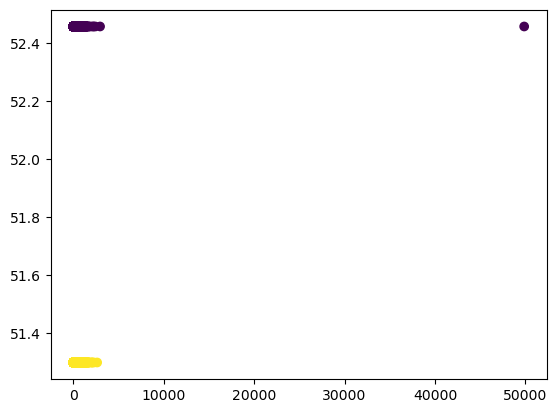

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(cats['sum_gamerounds'],predictions,c=np.where(cats['version'] == 'gate_30',0,1))
plt.show()